## read data, split data

In [2]:
import os
import pandas as pd
from datetime import datetime

directory = 'qr_takehome/'
files = os.listdir(directory)
file_dates = {file: datetime.strptime(file.split('_')[-1], '%Y%m%d.csv.parquet') for file in files}
# leave 3 months of data as test data
split_date = datetime.strptime('20230101', '%Y%m%d') 
train_files = [file for file, date in file_dates.items() if date < split_date]
test_files = [file for file, date in file_dates.items() if date >= split_date]
train_dataframes = [pd.read_parquet(os.path.join(directory, file)) for file in train_files]
test_dataframes = [pd.read_parquet(os.path.join(directory, file)) for file in test_files]
train_df = pd.concat(train_dataframes, ignore_index=True)
test_df = pd.concat(test_dataframes, ignore_index=True)
# If Q1 is less than 1 (make the test Q1 < 0.9999 to handle floating point precision), then the row should be excluded from the calibration of Y1.
# Similarly, if Q2 is less than 1, the row should be excluded from the calibration of Y2. Q1 and Q2 are used to indicate the quality of Y1 and Y2 respectively. And if they are less than 1, it means 
# that Y1 or Y2 are not in a good state.
train_df_Y1=train_df[train_df['Q1']>=0.9999]
train_df_Y2=train_df[train_df['Q2']>=0.9999]
test_df_Y1=test_df[test_df['Q1']>=0.9999]
test_df_Y2=test_df[test_df['Q2']>=0.9999]

## missing data handling

In [3]:
# Data that are 999999 are also missing values
train_df.replace(999999, pd.NA, inplace=True)
# Calculate the percentage of missing data in each row for train and test dataframes
percent_missing_train = train_df.isna().mean(axis=1)
# Filter out rows where more than 50% of the data is missing
cleaned_train_df = train_df[percent_missing_train <= 0.5]

cleaned_train_df_Y1=cleaned_train_df[cleaned_train_df['Q1']>=0.9999]
cleaned_train_df_Y2=cleaned_train_df[cleaned_train_df['Q2']>=0.9999]


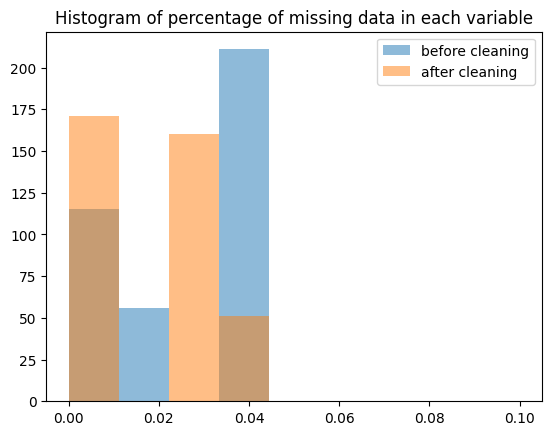

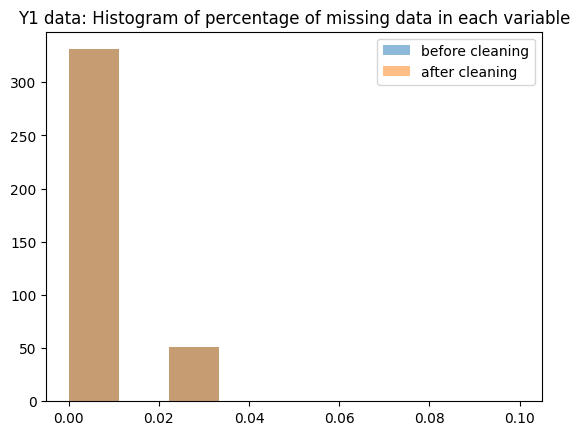

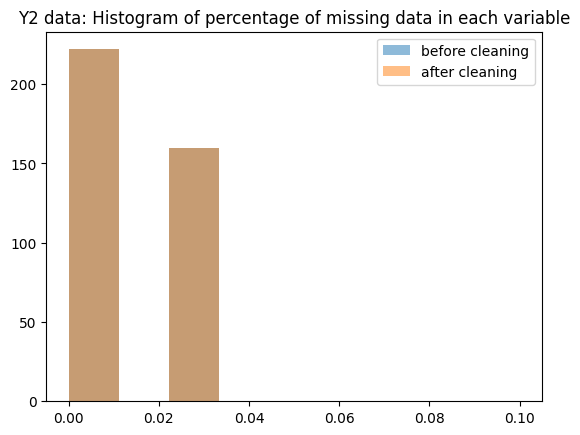

In [3]:
import numpy as np
import matplotlib.pyplot as plt 

# Determine the range and number of bins
bin_range = np.linspace(0, 0.1, 10)  # Example: creates 20 bins between 0 and 1

# Plot for train_df
plt.hist(train_df.isna().sum()/train_df.shape[0], bins=bin_range, alpha=0.5, label='before cleaning') 
plt.hist(cleaned_train_df.isna().sum()/cleaned_train_df.shape[0], bins=bin_range, alpha=0.5, label="after cleaning")
plt.legend()
plt.title('Histogram of percentage of missing data in each variable')
plt.show() 

# Repeat for train_df_Y1
plt.hist(train_df_Y1.isna().sum()/train_df_Y1.shape[0], bins=bin_range, alpha=0.5, label='before cleaning') 
plt.hist(cleaned_train_df_Y1.isna().sum()/cleaned_train_df_Y1.shape[0], bins=bin_range, alpha=0.5, label="after cleaning")
plt.legend()
plt.title('Y1 data: Histogram of percentage of missing data in each variable')
plt.show() 

# Repeat for train_df_Y2
plt.hist(train_df_Y2.isna().sum()/train_df_Y2.shape[0], bins=bin_range, alpha=0.5, label='before cleaning') 
plt.hist(cleaned_train_df_Y2.isna().sum()/cleaned_train_df_Y2.shape[0], bins=bin_range, alpha=0.5, label="after cleaning")
plt.legend()
plt.title('Y2 data: Histogram of percentage of missing data in each variable')
plt.show() 


In [4]:
print('Y1 data percentage: {}'.format(train_df_Y1.shape[0]/train_df.shape[0]))
print('Y2 data percentage: {}'.format(train_df_Y2.shape[0]/train_df.shape[0]))

Y1 data percentage: 0.9578185185185185
Y2 data percentage: 0.955767962962963


From this figure, I observe that all variables have values most of the time so no variable should be removed because of missing values

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random

random.seed(15)
dfs = random.sample(train_dataframes, 10) 

fig, axs = plt.subplots(10, 2, figsize=(60, 100))  # Adjust the figure size as needed
axs = axs.flatten()  # Flatten the array of axes

for i, df in enumerate(dfs):
    # Replace 999999 with NaN
    df.replace(999999, pd.NA, inplace=True)
    
    # Create a boolean DataFrame showing where data is missing
    missing_data = df.notna()
    
    # Calculate the proportion of missing values for each row
    missing_row_proportion = missing_data.mean(axis=1)
    
    # Create a mask for rows where more than 50% of the data is missing
    high_missing_mask = missing_row_proportion < 0.5
    
    #set rows that are going to be deleted to 0.5
    missing_data=missing_data.astype(float)
    for j in [0,1]:
        if (j==0):
            missing_data_copy=missing_data.copy()
            missing_data_copy.loc[df['Q1']>=0.9999]*=0.25
            missing_data_copy.loc[high_missing_mask,:]=0.5
            sns.heatmap(missing_data_copy, cbar=True, ax=axs[2*i+j], cmap='viridis', alpha=0.8)
        else:
            missing_data.loc[df['Q2']>=0.9999]*=0.25
            missing_data.loc[high_missing_mask,:]=0.5
            sns.heatmap(missing_data, cbar=True, ax=axs[2*i+j], cmap='viridis', alpha=0.8)

# Hide any unused subplots
for j in range(i+1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


These heatmaps show positions of missing data in a few randomly selected days.

1. each row consists of the same day of data, each colored for Y1(left) and Y2(right)
2. purple are missing data
3. greenish blue lines are deleted rows containing more than 50% of missing data 
4. yellow are good data not selected 
3. grey blue are good data selected. On the left, grey blue are good data selected for Y1; On the right, grey blue are good data selected for Y2; 

Observations:
1. Some variables have missing values continuously in a time interval, which can hinder performance and are difficult to impute accurately.
2. Removing rows with more than 50% or missing values did not solve this problem
3. Some variables are very stable as also suggested in the earlier histogram
4. There is a pattern where missing data are especially prevalent during openning and closing hours, which suggest time dependence of the model

In [6]:
import pickle
with open('df_storage/cleaned_train_df_Y1.pkl', 'wb') as file:
    pickle.dump(cleaned_train_df_Y1, file)
with open('df_storage/cleaned_train_df_Y2.pkl', 'wb') as file:
    pickle.dump(cleaned_train_df_Y2, file)
with open('df_storage/test_df_Y1.pkl', 'wb') as file:
    pickle.dump(test_df_Y1, file)
with open('df_storage/test_df_Y2.pkl', 'wb') as file:
    pickle.dump(test_df_Y2, file)